## パラメータの設定

In [60]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm

import func_solve_newton
import other_module
importlib.reload(other_module)
importlib.reload(func_solve_newton)
from func_solve_newton import f_newton, solve_newton, get_theta_of_maxL
from other_module import reaching_point, plot

In [3]:
# initial param
v0 = 100.0 / 3.6  # [m/s]
m = 0.1  # [kg]
b = 0.1  # [kg/s]

### 放物線

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


最大飛距離の時のそれぞれのパラメータ


,theta,l,err
4,25,21.233538,-0.00985


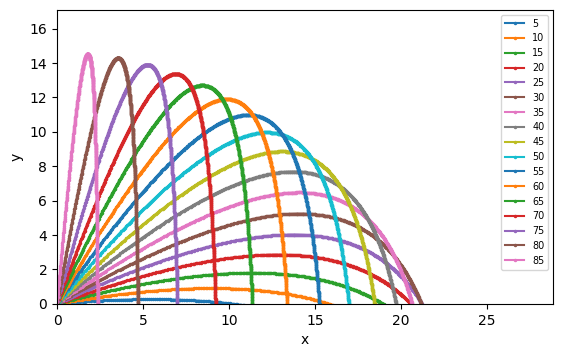

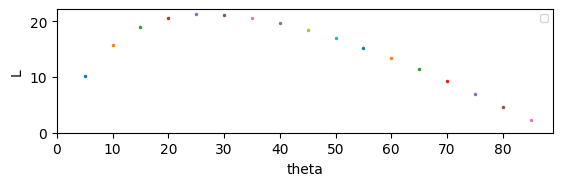

In [51]:
def max_length(v0=100.0 / 3.6, m=0.1, b=0.1, n_t=101):
    # MKS units: m, kg, s
    g = 9.8  # [m/s^2]

    t_start = 0  # [s]
    t_end = 5.0  # [s]

    # Results will be stored into a list as namedtuple
    L = pd.DataFrame(columns=['theta', 'xt', 'yt', "l", "err"])
    num_theta = (90 - 5) // 5

    for i, theta_degree in enumerate(range(5, 90, 5)):
        theta = theta_degree * (np.pi / 180)  # radian

        # X0 = [x0, v0_x, y0, v0_y]
        X0 = np.array([0, v0 * np.cos(theta), 0, v0 * np.sin(theta)])

        # Solve Newton equation
        # x(t), y(t)
        xt, _, yt, _ = solve_newton(eq_params=(g, b/m), X0=X0, t_range=(t_start, t_end), n_t=n_t)
        l, err = reaching_point(xt, yt, num_exclude_point=n_t//20)

        # Store result
        val = {"theta": theta_degree, "xt": xt, "yt": yt, "l": l, "err": err}
        L.loc[i, :] = val
    
    max_L = L[L.l == L.l.max()]

    plot(L, x='xt', y='yt', label='theta', xlabel='x', ylabel='y')
    plot(L, x='theta', y='l', xlabel='theta', ylabel='L')
    plt.savefig('../pic/related_theta_L.png')
    return max_L

L = max_length(v0, m, b, n_t=1000)
print('最大飛距離の時のそれぞれのパラメータ')
L[['theta', 'l', 'err']]

### 抵抗係数と角度

In [53]:
def depend_theta_bm(v0=100.0 / 3.6, bm=1., n_t=101, n_theta=100, n:int=2):
    # MKS units: m, kg, s
    g = 9.8  # [m/s^2]
    t_range = (0, 10.0)  # [s]
    theta_range = (1/2*np.pi, 1/180*np.pi)

    for i in range(n):
        theta_maxL, max_L, _ = get_theta_of_maxL(
            theta_range, t_range, n_theta, n_t, bm=bm
            ).values.squeeze()
        unit_scale = (theta_range[0] - theta_range[1]) / n_theta
        theta_range = (theta_maxL + unit_scale, theta_maxL - unit_scale)
    return theta_maxL

In [54]:
n = 50
_depend_theta_bm = np.zeros((n, 3))
vec_bm = np.zeros(n)
bm_range = np.linspace(0.0, 1, n)
for i, bm in enumerate(tqdm(bm_range)):
    max_point = depend_theta_bm(bm=bm, n_t=10000, n_theta=10, n=10)
    _depend_theta_bm[i, :] = max_point
    vec_bm[i] = bm
    

100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


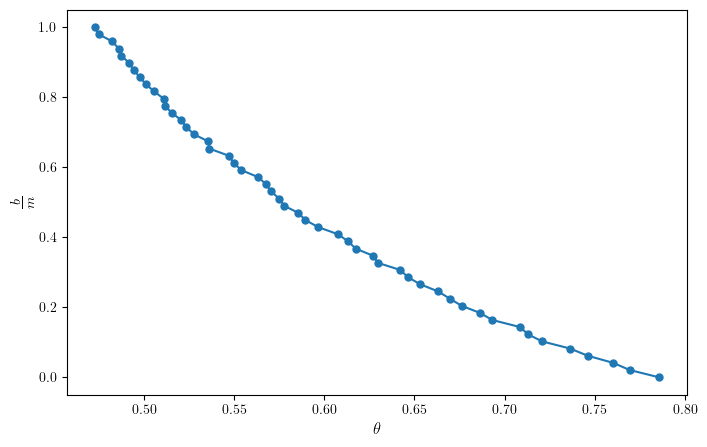

In [65]:
theta, l, err = _depend_theta_bm.T

matplotlib.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(theta, vec_bm, marker='.', markersize=10)
ax.set_xlabel(r'$\theta$', fontsize=12)
ax.set_ylabel(r'$\frac{b}{m}$', fontsize=14)
fig.savefig('../pic/related_theta_bm.png')